# DistillBert for training

**Installing and importing the required packages**

In [23]:
!pip install transformers
!pip install tensorflow_addons

In [24]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf 
from transformers import  TFDistilBertModel
from transformers import DistilBertTokenizerFast, DistilBertConfig
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

**Downloading and initializing the tokenizer**

In [25]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

**Loading Data**

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Read the file IMDB Dataset.csv.zip as a pandas dataframe
df_train = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/train_dataset.csv", index_col=0)
df_augmented_train = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/augmented_train_dataset.csv", index_col=0)
df_val = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/val_dataset.csv", index_col=0)
df_test = pd.read_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/test_dataset.csv", index_col=0)

**Visualizing class imbalance in all four datasets**

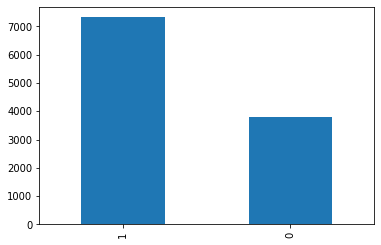

In [28]:
df_train['Label'].value_counts().plot(kind='bar')

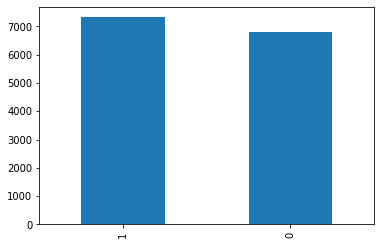

In [29]:
df_augmented_train['Label'].value_counts().plot(kind='bar')

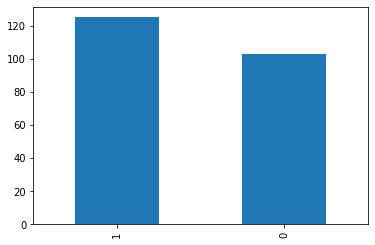

In [30]:
df_test['Label'].value_counts().plot(kind='bar')

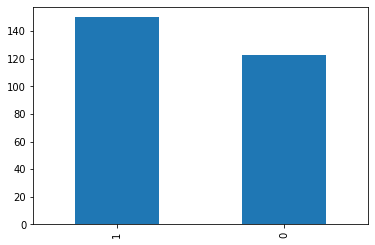

In [31]:
df_val['Label'].value_counts().plot(kind='bar')

# Unbalanced data

**Using df_train, df_val, df_test for finetuning DistillBert model**

In [32]:
X_train=list(df_train.Sentences)
X_val=list(df_val.Sentences)
X_test=list(df_test.Sentences)


y_train=list(df_train.Label)
y_val=list(df_val.Label)
y_test=list(df_test.Label)

**Tokenizing the Sentences and returning the input ids and attention masks which is the combined input to BERT**

In [33]:
def batch_encode(tokenizer, texts, batch_size=128, max_length=1000):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed 
    into a pre-trained transformer model.
    
    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="tf", padding = 'max_length', max_length= max_length, truncation= True)
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
      
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [34]:
# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)

# Encode X_valid
X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_val)

# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)

**Taking the hidden state of DistillBERT's last embedding layer and getting only the sentence embeddings (specifically the CLS token of the last layer which has information about sentence)**




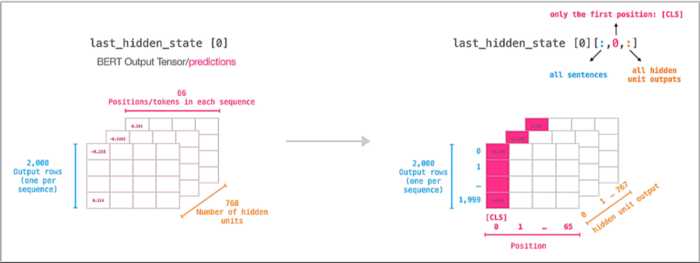




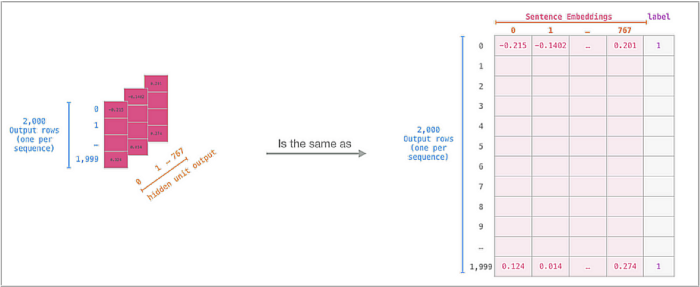

Source of images:
http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

In [35]:

def build_model(transformer, max_length=1000):
    """
    Template for building a model off of the BERT or DistilBERT architecture
    for a binary classification task.
    
    Input:
      - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                      with no added classification head attached.
      - max_length:   integer controlling the maximum number of encoded tokens 
                      in a given sequence.
    
    Output:
      - model:        a compiled tf.keras.Model with added classification layers 
                      on top of the base pre-trained model architecture.
    """
    
    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=42) 
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    #last_hidden_state = transformer([input_ids_layer])[0]
    # We only care about DistilBERT's output for the [CLS] token, which is located
    # at index 0.  Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state[:, 0, :]
    D1 = tf.keras.layers.Dropout(0.2, seed=42)(cls_token)
    
    X = tf.keras.layers.Dense(256,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D1)
    
    D2 = tf.keras.layers.Dropout(0.2, seed=42)(X)
    
    X = tf.keras.layers.Dense(32,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D2)

                            
    D3 = tf.keras.layers.Dropout(0.2, seed=42)(X)

    
    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  # CONSIDER USING CONSTRAINT
                                   bias_initializer='zeros'
                                   )(D3)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(learning_rate= 5e-5), loss='bce', metrics=['accuracy'])#)
    return model

In [36]:
config = DistilBertConfig(dropout=0.2, 
                          attention_dropout=0.1, 
                          output_hidden_states=False, output_attentions=False,return_dict =True)

distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

for layer in distilBERT.layers:
    layer.trainable = False

# Build model
model = build_model(distilBERT)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


**The overall model architecture is TFDistillBert with a custom classification head of Dense(256), Dense(32), Dense(1 with sigmoid activation) and dropout of 0.2 in between.**

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 1000)]       0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]   

**Model training for Frozen DistillBert with classification head**

In [38]:
# Train the model
train_history1 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = np.array(y_train),
    epochs = 8,
    batch_size = 64,
    validation_data = ([X_valid_ids, X_valid_attention], np.array(y_val)), verbose=1
)

Epoch 1/8
174/174 [==============================] - 335s 2s/step - loss: 0.6098 - accuracy: 0.6659 - val_loss: 0.6623 - val_accuracy: 0.5714
Epoch 2/8
174/174 [==============================] - 329s 2s/step - loss: 0.4976 - accuracy: 0.7556 - val_loss: 0.5962 - val_accuracy: 0.7070
Epoch 3/8
174/174 [==============================] - 329s 2s/step - loss: 0.4171 - accuracy: 0.8100 - val_loss: 0.5735 - val_accuracy: 0.7473
Epoch 4/8
174/174 [==============================] - 329s 2s/step - loss: 0.3849 - accuracy: 0.8305 - val_loss: 0.5708 - val_accuracy: 0.7289
Epoch 5/8
174/174 [==============================] - 329s 2s/step - loss: 0.3625 - accuracy: 0.8402 - val_loss: 0.5661 - val_accuracy: 0.7509
Epoch 6/8
174/174 [==============================] - 329s 2s/step - loss: 0.3553 - accuracy: 0.8444 - val_loss: 0.5578 - val_accuracy: 0.7473
Epoch 7/8
174/174 [==============================] - 329s 2s/step - loss: 0.3410 - accuracy: 0.8535 - val_loss: 0.5535 - val_accuracy: 0.7509
Epoch 

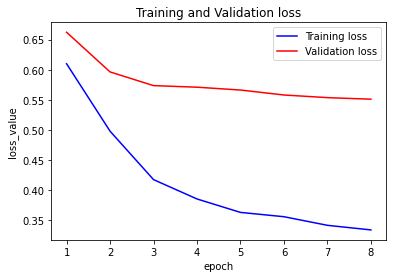

In [45]:
train_loss = train_history1.history['loss']
val_loss = train_history1.history['val_loss']

epochs = range(1,len(train_loss)+1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.legend()
plt.show()

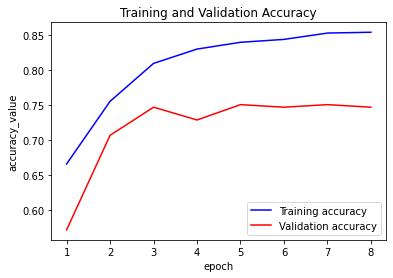

In [46]:
train_acc = train_history1.history['accuracy']
val_acc = train_history1.history['val_accuracy']

epochs = range(1,len(train_acc)+1)

plt.figure()
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label ='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy_value')
plt.legend()
plt.show()

**Trying the model on test data**

In [47]:
loss, accuracy = model.evaluate([X_test_ids, X_test_attention], np.array(y_test))
print("test loss: ", loss)
print("test accuracy: ", accuracy)

8/8 [==============================] - 5s 667ms/step - loss: 0.5885 - accuracy: 0.6798
test loss:  0.5884889960289001
test accuracy:  0.6798245906829834


# Balanced data

**Tokenizing augmented dataset with class balance**

In [48]:
X_train_aug= list(df_augmented_train.Sentences)
y_train_aug= list(df_augmented_train.Label)

In [49]:
# Encode X_train_aug
X_train_aug_ids, X_train_aug_attention = batch_encode(tokenizer, X_train_aug)

**Training DistillBert on augmented dataset at the same time keeping validation data same as before**

In [50]:
tf.keras.backend.clear_session()

In [51]:
# Train the model
train_history2 = model.fit(
    x = [X_train_aug_ids, X_train_aug_attention],
    y = np.array(y_train_aug),
    epochs = 7,
    batch_size = 64,
    validation_data = ([X_valid_ids, X_valid_attention], np.array(y_val)), verbose=1
)

Epoch 1/7
221/221 [==============================] - 416s 2s/step - loss: 0.5096 - accuracy: 0.7458 - val_loss: 0.5667 - val_accuracy: 0.7033
Epoch 2/7
221/221 [==============================] - 415s 2s/step - loss: 0.5022 - accuracy: 0.7529 - val_loss: 0.5694 - val_accuracy: 0.7143
Epoch 3/7
221/221 [==============================] - 416s 2s/step - loss: 0.4854 - accuracy: 0.7642 - val_loss: 0.5840 - val_accuracy: 0.7070
Epoch 4/7
221/221 [==============================] - 416s 2s/step - loss: 0.4797 - accuracy: 0.7678 - val_loss: 0.5922 - val_accuracy: 0.7033
Epoch 5/7
221/221 [==============================] - 416s 2s/step - loss: 0.4765 - accuracy: 0.7749 - val_loss: 0.5933 - val_accuracy: 0.7106
Epoch 6/7
221/221 [==============================] - 416s 2s/step - loss: 0.4729 - accuracy: 0.7688 - val_loss: 0.5923 - val_accuracy: 0.6923
Epoch 7/7
221/221 [==============================] - 416s 2s/step - loss: 0.4674 - accuracy: 0.7747 - val_loss: 0.5973 - val_accuracy: 0.6923


**Trying the model on test data**

In [52]:
loss, accuracy = model.evaluate([X_test_ids, X_test_attention], np.array(y_test))
print("test loss: ", loss)
print("test accuracy: ", accuracy)

8/8 [==============================] - 5s 667ms/step - loss: 0.6270 - accuracy: 0.6842
test loss:  0.6269809603691101
test accuracy:  0.6842105388641357


**Plotting the training history for both datasets to measure performance**

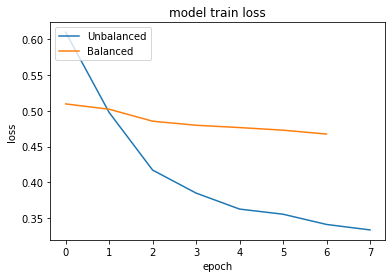

In [53]:
plt.plot(train_history1.history['loss'])
plt.plot(train_history2.history['loss'])
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Unbalanced', 'Balanced'], loc='upper left')
plt.show()

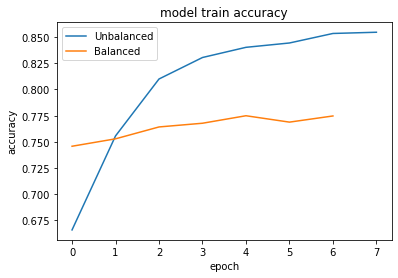

In [55]:
plt.plot(train_history1.history['accuracy'])
plt.plot(train_history2.history['accuracy'])
plt.title('model train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Unbalanced', 'Balanced'], loc='upper left')
plt.show()

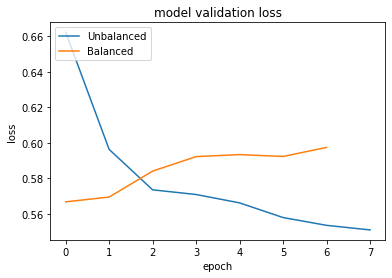

In [54]:
plt.plot(train_history1.history['val_loss'])
plt.plot(train_history2.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Unbalanced', 'Balanced'], loc='upper left')
plt.show()

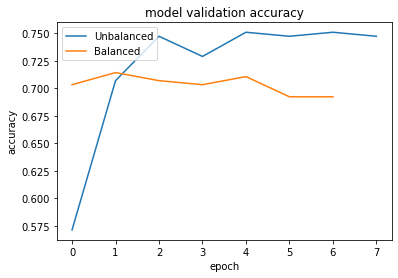

In [56]:
plt.plot(train_history1.history['val_accuracy'])
plt.plot(train_history2.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Unbalanced', 'Balanced'], loc='upper left')
plt.show()

**Inference: Using DistillBert on the augmented dataset resulted in decrease of model performance. This happens because the upsampling a large corpus generally leads to a very mixed dataset which leads to difficulty in learning patterns in the data**